In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import nibabel as nib


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

## Functions

In [2]:
def get_neighborhood(point, points, max_dist):
    # Get the Euclidean distance between the point and all other points
    distances = np.linalg.norm(points - point, axis=1)
    
    # Get the indices of the points within the neighborhood
    neighborhood_indices = np.where(distances <= max_dist)[0]
    
    # Get the points within the neighborhood
    neighborhood = points[neighborhood_indices]
    
    #neighborhood = [pt for pt in neighborhood if pt != point]
    
    return neighborhood_indices, neighborhood


def get_magnitude(v):
    return np.linalg.norm(v)


def angle_between_vectors(v1, v2):
    # arccos (A dot B / |A||B|)
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    
    # Compute the magnitudes of the vectors
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0, 0
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Clip the cosine value to the range [-1, 1] to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

m1 = np.array([0, 1, 0])
f1 = np.array([0, 1, 4])

m2 = np.array([0, 3, 0])
f2 = np.array([0, 4, 4])

# Example vectors
# v1 = np.array([1, 0, 0])
# v2 = np.array([1, 0.5, 0])

v1 = f1 - m1
v2 = f2 - m2

# Compute the angle between the vectors
angle_rad, angle_deg = angle_between_vectors(v1, v2)

# Check if the angle exceeds a certain threshold (e.g., 45 degrees)
threshold_deg = 45
if angle_deg > threshold_deg:
    print(f"The vectors differ by a lot: {angle_deg:.2f} degrees")
else:
    print(f"The vectors do not differ by a lot: {angle_deg:.2f} degrees")

The vectors do not differ by a lot: 14.04 degrees


## Load deformation field

In [ ]:
CURR_IDX = 350  # Only consider the correspondences of this index

# Input parameters
base_path = "data/base_unique_correspondences/registered_output/deformation3d.npy"
mpoints_path = "data/base_unique_correspondences/mpoints.npy"
fpoints_path = "data/base_unique_correspondences/fpoints.npy"

# Load the numpy array and compute the jacobian determinant
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Get only elements that are of the current index
mpoints = mpoints[mpoints[:, 0] == CURR_IDX]
fpoints = fpoints[fpoints[:, 0] == CURR_IDX]

# Change the 0th index in each element to 0
mpoints[:, 0] = 0
fpoints[:, 0] = 0

cvectors = fpoints - mpoints  # Correspondence vectors

print("Correspondence point shape:", fpoints.shape)
print("First five fixed points:\n", fpoints[:5])
print("First five moving points:\n", mpoints[:5])
print("First five correspondence vectors:\n", cvectors[:5])

Correspondence point shape: (1326, 3)
First five fixed points:
 [[  0.  10. 173.]
 [  0.  10. 174.]
 [  0.  10. 175.]
 [  0.  10. 176.]
 [  0.  10. 181.]]
First five moving points:
 [[  0.  17. 178.]
 [  0.  17. 179.]
 [  0.  18. 172.]
 [  0.  18. 180.]
 [  0.  15. 187.]]
First five correspondence vectors:
 [[ 0. -7. -5.]
 [ 0. -7. -5.]
 [ 0. -8.  3.]
 [ 0. -8. -4.]
 [ 0. -5. -6.]]


## Remove INTERSECTING correspondences

In [4]:
def remove_intersections(mpoints: np.ndarray, fpoints: np.ndarray, idx: int=0) -> tuple:
    """
    Remove intersecting correspondences between the moving and fixed points.
    
    Parameters:
    mpoints (np.ndarray): The moving points.
    fpoints (np.ndarray): The fixed points.
    idx (int): The index of the correspondences.
    
    Returns:
    tuple: The moving and fixed correspondences with intersecting points removed.
    """
    mcorrespondences = []
    fcorrespondences = []

    mpts = mpoints.copy()[:, 1:]
    fpts = fpoints.copy()[:, 1:]

    # Swap correspondences if they intersect
    fpts, ipts = correspondences.swap_correspondences(mpts, fpts)
    min_intersection_count = len(ipts)
    curr_fpts = fpts
    # Keep swapping until the number of intersections no longer decreases
    while True:
        fpts, ipts_temp = correspondences.swap_correspondences(mpts, fpts)
        intersection_count = len(ipts_temp)
        #print("Number of intersecting points:", intersection_count)
        if intersection_count < min_intersection_count:
            min_intersection_count = intersection_count
            curr_fpts = fpts
        else:
            break
    fpts = curr_fpts

    # Detect intersecting line segments
    intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(mpts, fpts)

    # Remove intersecting segments from correspondences
    new_mpts = mpts.copy()
    new_fpts = fpts.copy()
    while len(intersecting_indices) != 0:
        new_mpts = [element for i, element in enumerate(new_mpts) if i not in intersecting_indices[:, 0]]
        new_fpts = [element for i, element in enumerate(new_fpts) if i not in intersecting_indices[:, 0]]
        intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(new_mpts, new_fpts)
        num_intersections = len(intersecting_indices)
        #print("Number of intersecting segments left:", num_intersections)
        if num_intersections != 0:
            intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(new_mpts, new_fpts)
    new_mpts = np.array(new_mpts)
    new_fpts = np.array(new_fpts)


    new_col = np.full((new_mpts.shape[0], 1), idx)
    new_mpts = np.hstack((new_col, new_mpts))
    new_fpts = np.hstack((new_col, new_fpts))
    mcorrespondences.append(new_mpts)
    fcorrespondences.append(new_fpts)

    mcorrespondences = np.concatenate(mcorrespondences, axis=0)
    fcorrespondences = np.concatenate(fcorrespondences, axis=0)
    return mcorrespondences, fcorrespondences

# Remove intersecting correspondences
mpoints_intersection_removed, fpoints_intersection_removed = remove_intersections(mpoints, fpoints)
print("Starting number of correspondences:", mpoints.shape[0])
print("Number of correspondences after removing intersections:", mpoints_intersection_removed.shape[0])
print("Number of correspondences removed:", mpoints.shape[0] - mpoints_intersection_removed.shape[0])

Starting number of correspondences: 1326
Number of correspondences after removing intersections: 1246
Number of correspondences removed: 80


## Compute Jacobian of points with INTERSECTIONS removed.

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.056910037994384766s
Computing dy
dy calculated in 0.17752599716186523s
Computing dx
dx calculated in 0.2801177501678467s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.048204898834228516s
Computing dy
dy calculated in 0.17505383491516113s
Computing dx
dx calculated in 0.27982258796691895s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 168
After - minimum Jacobian determinant: -4.141267670622895
After - maximum Jacobian determinant: 8.847872374160026


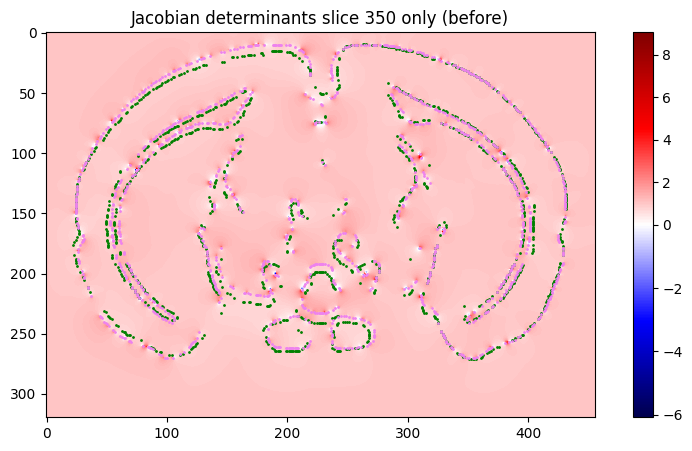

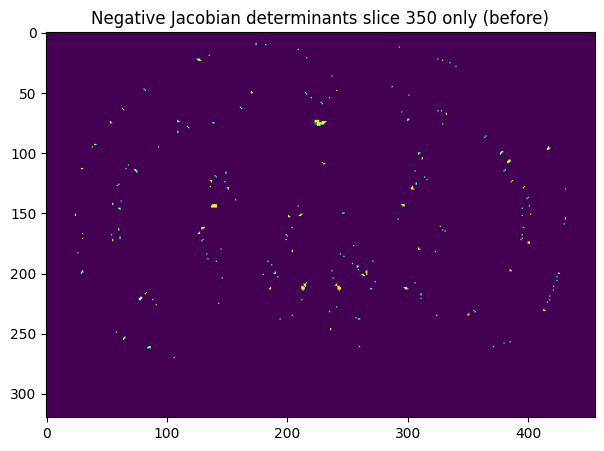

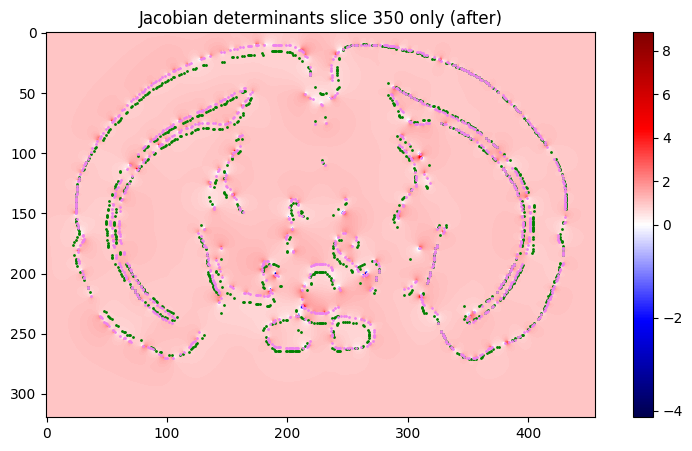

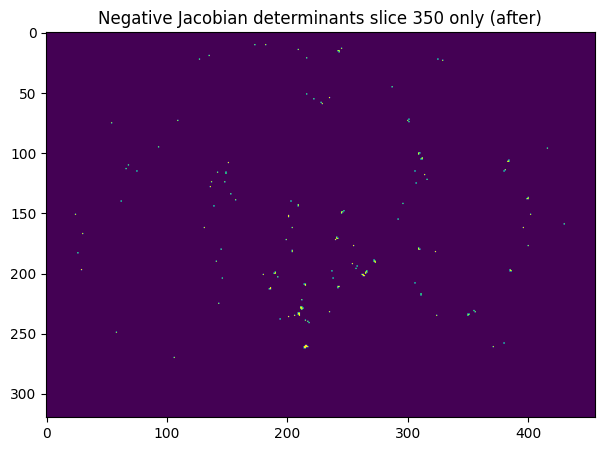

In [7]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_intersection_removed, fpoints_intersection_removed)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_intersection_removed[:, 2], mpoints_intersection_removed[:, 1], c="g", s=1)
plt.scatter(fpoints_intersection_removed[:, 2], fpoints_intersection_removed[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

## Remove ORIENTATION outliers from correspondence points

In [11]:
MAX_DIST = 30
MAX_DEG = 60

mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Number of outliers: 230 out of 1326 points
Number of outliers: 17 out of 1326 points
Number of outliers: 1 out of 1326 points
Number of outliers: 0 out of 1326 points

Number of runs: 4
Number of points removed: 248
Number of points in the corrected points: 1078 / 1326


## Compute Jacobian of orientation-filtered points

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.055773019790649414s
Computing dy
dy calculated in 0.17666053771972656s
Computing dx
dx calculated in 0.27720117568969727s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.046994924545288086s
Computing dy
dy calculated in 0.18354201316833496s
Computing dx
dx calculated in 0.2986447811126709s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 177
After - minimum Jacobian determinant: -3.705544075115345
After - maximum Jacobian determinant: 6.613283330845526


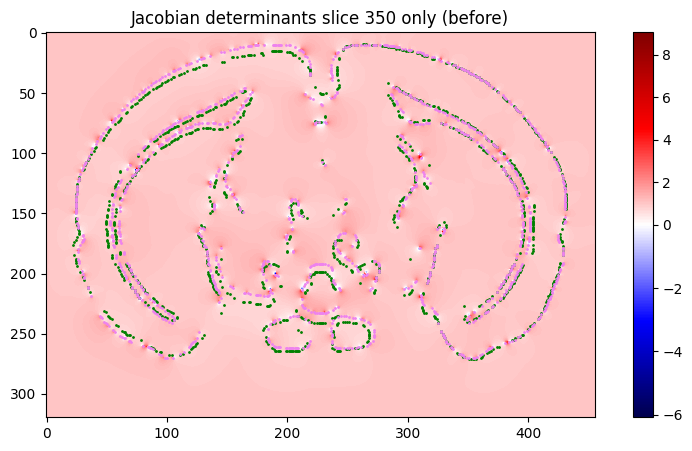

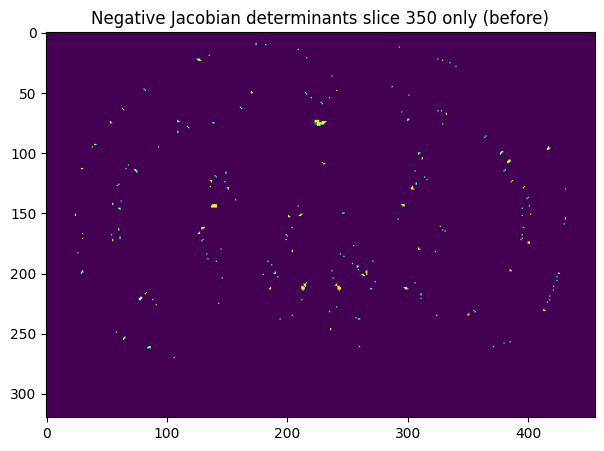

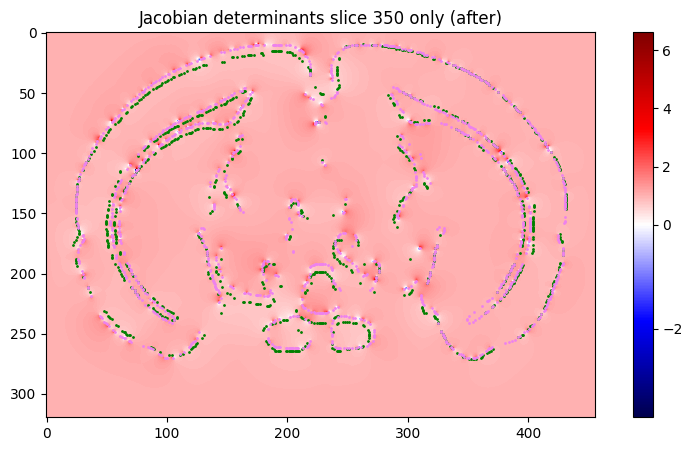

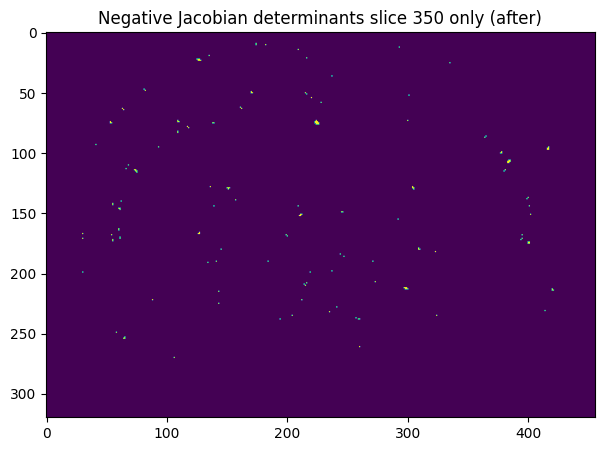

In [12]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

___

## Remove MAGNITUDE outliers

In [8]:
MAX_MAGNITUDE_MULT_GT = 0.5
MAX_MAGNITUDE_MULT_LT = 0.5
MAX_MAGNITUDE_DIFF_GT = 2
MAX_MAGNITUDE_DIFF_LT = 2
MAX_DIST = 20
DEBUG = False


mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

# Process point magnitudes
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_magnitude = magnitudes[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_magnitude = np.mean(magnitudes[neighborhood_idx])
        median_magnitude = np.median(magnitudes[neighborhood_idx])
        std_magnitude = np.std(magnitudes[neighborhood_idx])
        
        if DEBUG:
            print("\nCurrent point:", curr_point)
            print("Current magnitude:", curr_magnitude)
            print("Average magnitude:", average_magnitude)
            print("Median magnitude:", median_magnitude)
            print("Standard deviation of magnitudes:", std_magnitude)
        
        # Remove the point if the magnitude is greater than the average magnitude by a certain threshold
        threshold_gt = max(average_magnitude + average_magnitude * MAX_MAGNITUDE_MULT_GT, 
                           average_magnitude + MAX_MAGNITUDE_DIFF_GT)
        if curr_magnitude > threshold_gt:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a larger relative magnitude of {curr_magnitude} > {threshold_gt} ({average_magnitude}).")
            
        # Remove the point if the magnitude is less than the average magnitude by a certain threshold
        threshold_lt = max(average_magnitude - average_magnitude * MAX_MAGNITUDE_MULT_LT, 
                           average_magnitude - MAX_MAGNITUDE_DIFF_LT,
                           0)
        if curr_magnitude < threshold_lt and average_magnitude - MAX_MAGNITUDE_DIFF_LT > 0:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a smaller relative magnitude of {curr_magnitude} < {threshold_lt} ({average_magnitude}).")

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1
    break

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Point 50 has a larger relative magnitude of 4.47213595499958 > 3.207213595499958 (1.2072135954999579).
Point 68 has a larger relative magnitude of 5.0 > 4.9799953278137 (2.979995327813701).
Point 72 has a larger relative magnitude of 5.830951894845301 > 5.021324625053363 (3.0213246250533627).
Point 79 has a larger relative magnitude of 9.219544457292887 > 7.8918708441517404 (5.261247229434494).
Point 81 has a larger relative magnitude of 9.219544457292887 > 7.8918708441517404 (5.261247229434494).
Point 88 has a larger relative magnitude of 6.0 > 3.824160450111475 (1.824160450111475).
Point 91 has a larger relative magnitude of 4.47213595499958 > 3.718897292216738 (1.718897292216738).
Point 94 has a larger relative magnitude of 4.47213595499958 > 3.3829524276059013 (1.3829524276059013).
Point 119 has a smaller relative magnitude of 0.0 < 3.1505101394170643 (5.150510139417064).
Point 125 has a smaller relative magnitude of 0.0 < 3.3169458057417165 (5.3169458057417165).
Point 128 has a sm

## Compute Jacobian of magnitude-filtered points

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05780839920043945s
Computing dy
dy calculated in 0.17915701866149902s
Computing dx
dx calculated in 0.28028392791748047s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.050628662109375s
Computing dy
dy calculated in 0.18236327171325684s
Computing dx
dx calculated in 0.28444957733154297s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 204
After - minimum Jacobian determinant: -3.9731419957669822
After - maximum Jacobian determinant: 7.441483621937265


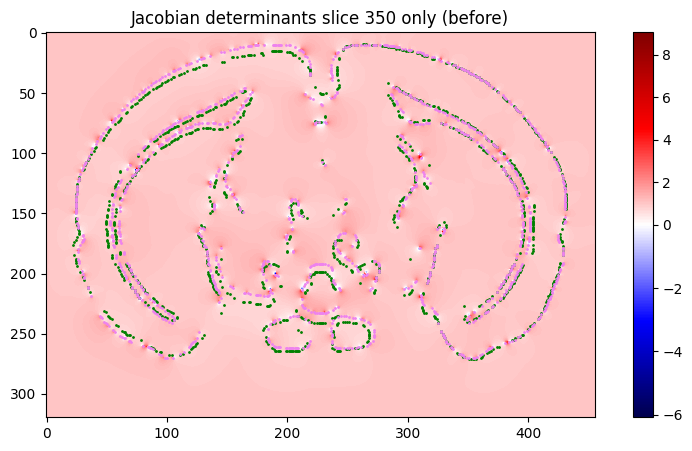

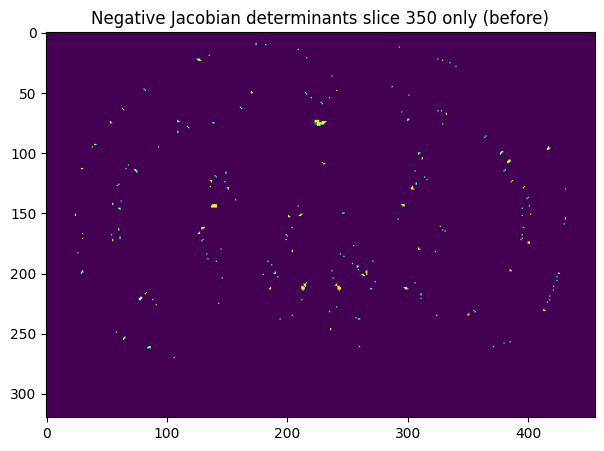

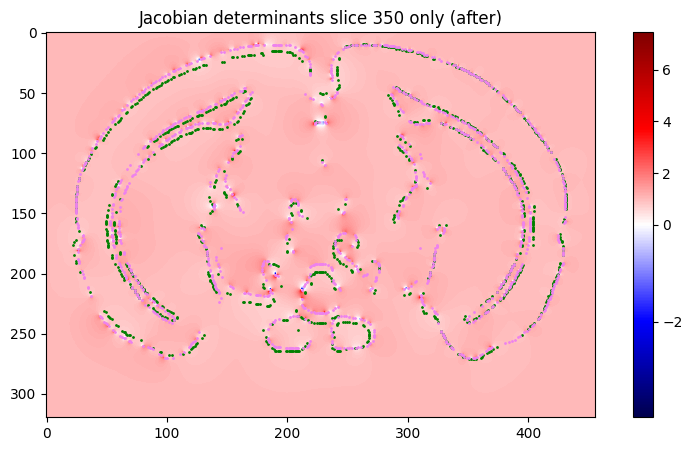

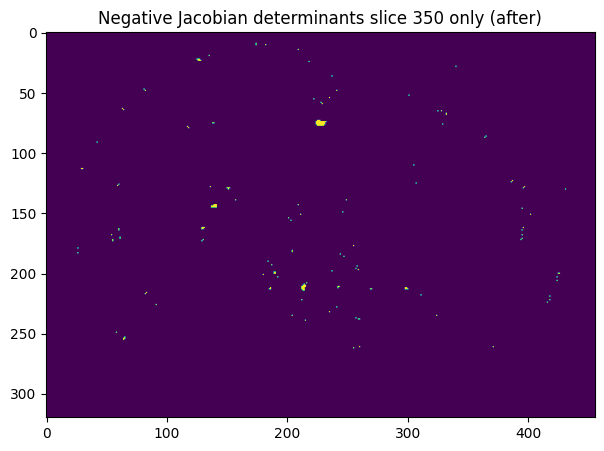

In [9]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

___
## Combine all

### Run intersection removal

In [5]:
# Start with intersecting point removal
mpoints_intersection_removed, fpoints_intersection_removed = remove_intersections(mpoints, fpoints)
curr_mpoints = mpoints_intersection_removed.copy()
curr_fpoints = fpoints_intersection_removed.copy()
curr_cvectors = curr_fpoints - curr_mpoints

print("Starting number of correspondences:", mpoints.shape[0])
print("Number of correspondences after removing intersections:", mpoints_intersection_removed.shape[0])
print("Number of correspondences removed:", mpoints.shape[0] - mpoints_intersection_removed.shape[0])

Starting number of correspondences: 1326
Number of correspondences after removing intersections: 1246
Number of correspondences removed: 80


### Run orientation removal

In [6]:
# Now remove orientation outliers
MAX_DIST = 30
MAX_DEG = 60

mpoints_corrected = curr_mpoints.copy()
fpoints_corrected = curr_fpoints.copy()
cvectors_corrected = curr_cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(curr_fpoints)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(curr_fpoints))

curr_mpoints = mpoints_corrected.copy()
curr_fpoints = fpoints_corrected.copy()
curr_cvectors = curr_fpoints - curr_mpoints

Number of outliers: 184 out of 1246 points
Number of outliers: 18 out of 1246 points
Number of outliers: 7 out of 1246 points
Number of outliers: 2 out of 1246 points
Number of outliers: 1 out of 1246 points
Number of outliers: 0 out of 1246 points

Number of runs: 6
Number of points removed: 212
Number of points in the corrected points: 1034 / 1246


### Check intermediary Jacobian

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.05408072471618652s
Computing dy
dy calculated in 0.17368364334106445s
Computing dx
dx calculated in 0.2733306884765625s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04714369773864746s
Computing dy
dy calculated in 0.18738961219787598s
Computing dx
dx calculated in 0.29939937591552734s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 92
After - minimum Jacobian determinant: -3.473978516992518
After - maximum Jacobian determinant: 5.79103541966788


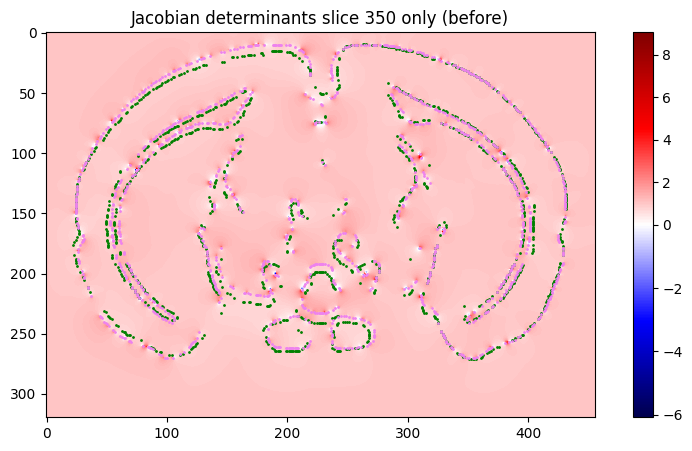

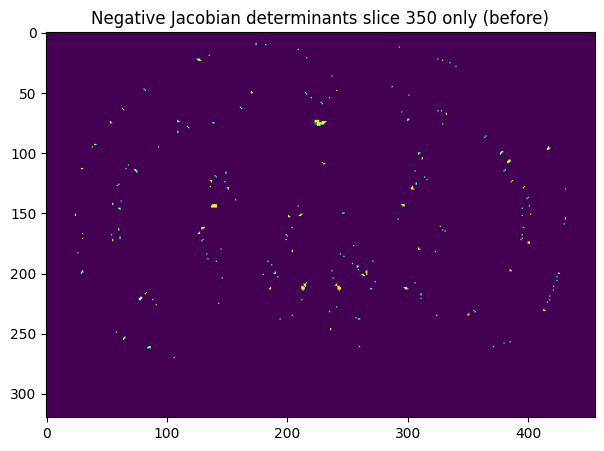

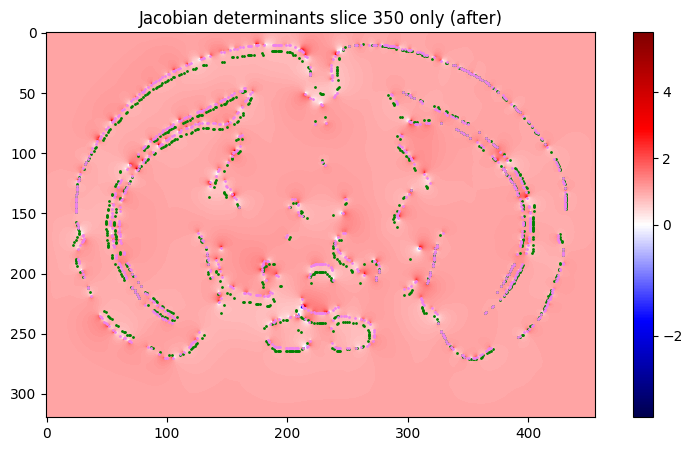

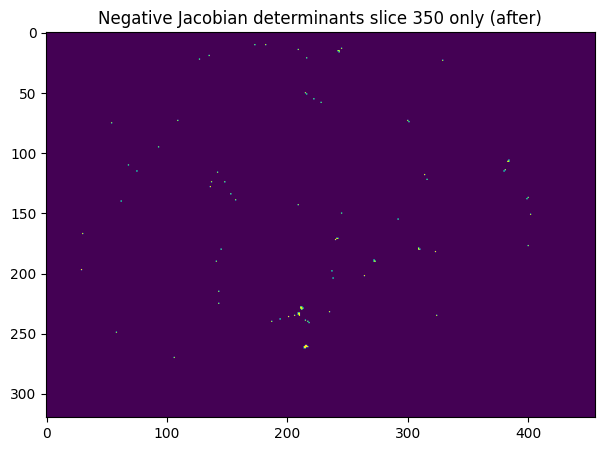

In [7]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

### Run magnitude removal

In [8]:
# Now run magnitude
MAX_MAGNITUDE_MULT_GT = 0.5
MAX_MAGNITUDE_MULT_LT = 0.5
MAX_MAGNITUDE_DIFF_GT = 2
MAX_MAGNITUDE_DIFF_LT = 2
MAX_DIST = 20
DEBUG = False


mpoints_corrected = curr_mpoints.copy()
fpoints_corrected = curr_fpoints.copy()
cvectors_corrected = curr_cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

# Process point magnitudes
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_magnitude = magnitudes[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_magnitude = np.mean(magnitudes[neighborhood_idx])
        median_magnitude = np.median(magnitudes[neighborhood_idx])
        std_magnitude = np.std(magnitudes[neighborhood_idx])
        
        if DEBUG:
            print("\nCurrent point:", curr_point)
            print("Current magnitude:", curr_magnitude)
            print("Average magnitude:", average_magnitude)
            print("Median magnitude:", median_magnitude)
            print("Standard deviation of magnitudes:", std_magnitude)
        
        # Remove the point if the magnitude is greater than the average magnitude by a certain threshold
        threshold_gt = max(average_magnitude + average_magnitude * MAX_MAGNITUDE_MULT_GT, 
                           average_magnitude + MAX_MAGNITUDE_DIFF_GT)
        if curr_magnitude > threshold_gt:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a larger relative magnitude of {curr_magnitude} > {threshold_gt} ({average_magnitude}).")
            
        # Remove the point if the magnitude is less than the average magnitude by a certain threshold
        threshold_lt = max(average_magnitude - average_magnitude * MAX_MAGNITUDE_MULT_LT, 
                           average_magnitude - MAX_MAGNITUDE_DIFF_LT,
                           0)
        if curr_magnitude < threshold_lt and average_magnitude - MAX_MAGNITUDE_DIFF_LT > 0:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a smaller relative magnitude of {curr_magnitude} < {threshold_lt} ({average_magnitude}).")

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1
    break

print("\n\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(curr_fpoints))

curr_mpoints = mpoints_corrected.copy()
curr_fpoints = fpoints_corrected.copy()
curr_cvectors = curr_fpoints - curr_mpoints

Point 33 has a smaller relative magnitude of 0.0 < 1.1765306226698662 (2.3530612453397324).
Point 47 has a larger relative magnitude of 7.211102550927978 > 5.236923245394814 (3.236923245394814).
Point 48 has a larger relative magnitude of 3.605551275463989 > 3.1630286277012187 (1.163028627701219).
Point 61 has a smaller relative magnitude of 0.0 < 1.4200713635801094 (2.840142727160219).
Point 65 has a larger relative magnitude of 5.830951894845301 > 5.308412907387316 (3.3084129073873156).
Point 72 has a larger relative magnitude of 9.219544457292887 > 7.725952270616403 (5.150634847077602).
Point 74 has a larger relative magnitude of 9.219544457292887 > 7.725952270616403 (5.150634847077602).
Point 80 has a larger relative magnitude of 4.47213595499958 > 3.0476517761412576 (1.0476517761412576).
Point 105 has a smaller relative magnitude of 0.0 < 2.9985639364982966 (4.998563936498297).
Point 110 has a smaller relative magnitude of 0.0 < 3.162296223352196 (5.162296223352196).
Point 112 has

In [9]:
print("Final number of correspondences:", curr_mpoints.shape[0])

Final number of correspondences: 892


## Compute Jacobian of final combined operation

fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.053308725357055664s
Computing dy


dy calculated in 0.1941983699798584s
Computing dx
dx calculated in 0.29062557220458984s
SITK deformation shape: (1, 320, 456, 3)
fdata.shape (1, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.0467989444732666s
Computing dy
dy calculated in 0.19110751152038574s
Computing dx
dx calculated in 0.31940245628356934s
SITK deformation shape: (1, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 386
Before - minimum Jacobian determinant: -6.08035232834211
Before - maximum Jacobian determinant: 9.046598660636274

After - number of negative or zero Jacobian determinants: 27
After - minimum Jacobian determinant: -0.8647245957286207
After - maximum Jacobian determinant: 3.9868281439344906


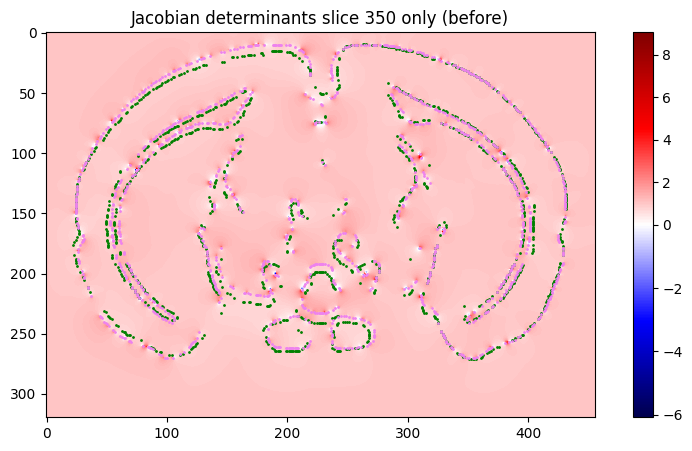

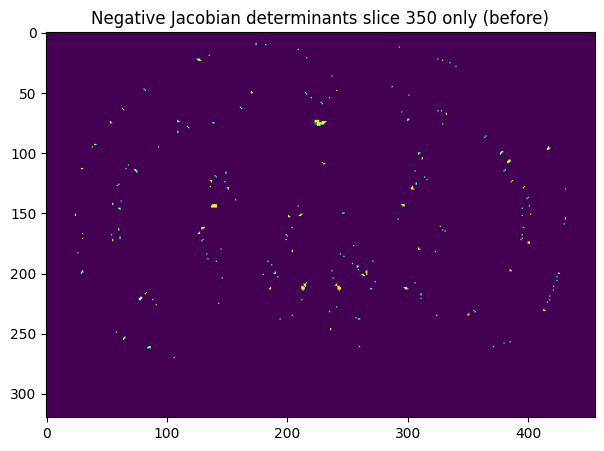

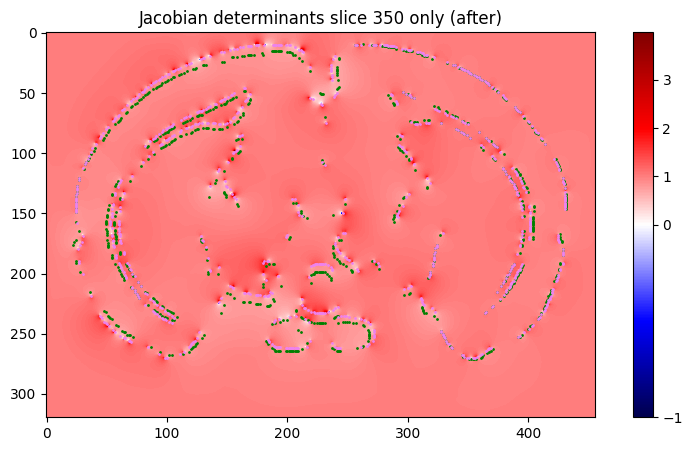

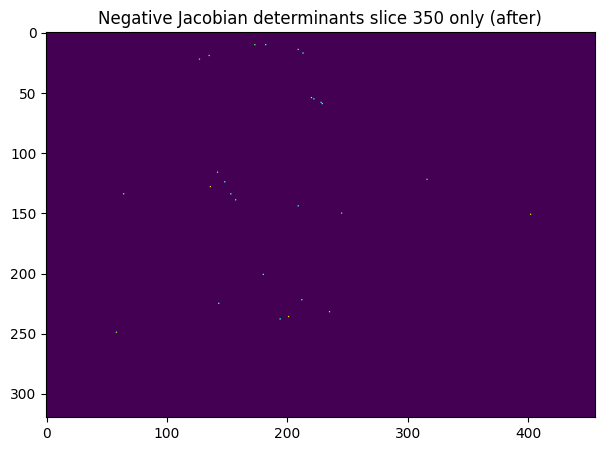

In [10]:
fixed_resolution = np.zeros((1, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()